In [1]:
import numpy as np

# Data pre-processing

### In general, before running diffnets your directory structure should look something like this... you have a directory that contains simulation data. In that directory you have a directory for each variant that contains all simulations for that given variant. Then, you should have pdb files to go with the trajectories.

In [12]:
practice_dir
|
|
 ----->simulation_data
         |----->var1
               ------sim1.xtc
               ------sim2.xtc
               ------sim3.xtc
         |----->var2
               ------sim1.xtc
               ------sim2.xtc
               ------sim3.xtc
          |var1.pdb
          |var2.pdb

### Here, copy the diffnets **diffnets/tests/data** to a new directory to practice running diffnets. This dataset only contains two variants and they each have one trajectory so your setup should look something like this:


In [ ]:
practice_dir
|
|
 ----->data
         |----->var1
               ------beta-peptide1.xtc
         |----->var2
               ------beta-peptide2.xtc
         |beta-peptide1.pdb
         |beta-peptide2.pdb

Now, cd into your practice dir

In [6]:
cd practice_dir/

/Users/mickdub/bowman_lab/scratch/practice_dir


### Now, we need to preprocess this simulation data to turn it into DiffNet input
-- Ultimately, we want to do that through the command line interface (CLI) which looks like this...

**python /path/to/diffnets/diffnets/cli/main.py process {sim_dirs} {pdb_fns} {outdir}**

In [7]:
sim_dirs = np.array(["./data/var1/",
            "./data/var2/"])
np.save("./traj_dirs.npy",sim_dirs)

pdb_fns = np.array(["./data/beta-peptide1.pdb",
                    "./data/beta-peptide2.pdb"])
np.save("./pdb_fns.npy",pdb_fns)

It's important to note that the order of **sim_dirs** and **pdb_fns** matters and the pdb order has to correspond to the trajectory order.

### Now, our directory looks something like this: 

In [ ]:
practice_dir
  |
  |pdb_fns.npy
  |traj_dirs.npy
  |
   ----->data
         |----->var1
               ------beta-peptide1.xtc
         |----->var2
               ------beta-peptide2.xtc
         |beta-peptide1.pdb
         |beta-peptide2.pdb

We are ready to run the data processing step! You should run this next step at the command line (outside of this notebook). Submit this to a CPU node on a cluster and request as many cores as are available on that node.

**python /path/to/diffnets/diffnets/cli/main.py process ./traj_dirs.npy ./pdb_fns.npy ./whitened_data**

--Optional parameters to add: 

    -a is an option specify an atom selection. The default will choose the C, CA, CB, and N atoms from both supplied PDB files. However, if your data requires a special atom selection, you must provide a numpy file that is a list of lists where each inner list contains the indices to select from each PDB file that you supplied. If your atom selection file is name "atom_sel.npy" then you should add the following to the above python command:
    
    -aatom_sel.npy (No space between the -a and the file name)
    
    -s is an option to set the stride for each dataset. This is useful if you have an excess of data (you typically only need tens to hundreds of thousance of simulation frames), OR if your datasets are unbalanced. For example, if var1 has 1 million structures, and var2 has 500,000 structures, you would want to set the stride to something like [10, 5] which will leave you with 100,000 structures from each variant. Save a numpy file called "stride.npy" that contains a list of integers where each integer designates the stride for a given variant. The order must follow the order that you supplied the PDBs.
    
    -sstride.npy (No space between the -s and the file names)

### Now, your directory should look something like this:

In [ ]:
practice_dir
  |pdb_fns.npy
  |traj_dirs.npy
  |
   ----->data
           ----->var1
                   |beta-peptide1.xtc
           ----->var2
                   |beta-peptide2.xtc
           |beta-peptide1.pdb
           |beta-peptide2.pdb
           |
   ----->whitened_data
           ----->indicators
                   |000000.npy
                   |000001.npy
           ----->data
                   |5001 .pt files (one for each simulation frame)
           ----->aligned_xtcs
                   |000000.xtc
                   |000001.xtc
           ----->whitened_xtcs
           |master.pdb
           |traj_dict.pkl
           |traj_lens.npy
           |cm.npy
           |c00.npy
           |uwm.npy
           |wm.npy

We have added a "whitened_data" directory that contains the following:

--an **aligned_xtcs** dir: one .xtc file for each trajectory where the trajectory has been stripped to (C,CA,CB,N) atoms and aligned to the first pdb supplied in pdb_fns (beta-peptide1.pdb). To change what atom selection you want to use, you can optionally supply {atom_sel} to the CLI command that generated this data. See the preprocess_data function in cli/main.py for more details.

--an **indicators** dir: one .npy file for each trajectory where the numbering matches the numbering in aligned_xtcs. The file is a numpy array that has as many values as simulation frames and indicates which variant the trajectory is of. It is zero-indexed so in our case, a value of 0 indicates var1 and a value of 1 indicates var2.

--a **data** dir: one .pt file (pytorch tensor) for each simulation frame. Lots of data means lots of files here.

--master.pdb: The stripped pdb (C,CA,CB,N) containing the set of atoms that is common to all variants. 

--traj_dict.pkl: Helper for plotting later (see Analysis.assign_labels_to_variants in analysis.py for more info).

--cm.npy: center of mass calculated from ALL simulation frames.

--c00.npy: covariance matrix calculated from ALL simulation frames. 

--wm.npy: whitening matrix which will be used as a layer in the DiffNet.

--uwm.npy: unwhitening matrix which will be used as a layer in the DiffNet.

# Training

### Here, we will train the diffnet

Ultimately, we want to run this command:
    
**python /path/to/diffnets/diffnets/cli/main.py train config.yml**

take a look at an example config.yml file at docs/train_sample.yml, but I will also display it here. Pay attention to the comments in the cell below.

Remember, we are still cd'd into practice_dir

In [ ]:
data_dir: './whitened_data'
n_epochs: 10 #How many times do we want to go through the training data?
act_map: [0,1] #initial label for var1 is 0 and for var2 its 1. 
               #Important note, if we had 4 variants (var1, var2, var3, var4) and we wanted to distingusih
               #var1,var2 from var3, var4 act_map would look like [0,0,1,1].
               #The order follows the order we originally put in pdb_fns.npy
lr: 0.0001
n_latent: 50 #Number of dimensions to reduce the data down to.
hidden_layer_sizes: [] #Leave blank array [] for default of 1 hidden layer
                       #that has 4x less nodes than input.
em_bounds: [[0.1,0.4],[0.6,0.9]] #one bound for each variant -- these are reasonable default values
do_em: True
em_batch_size: 150
nntype: 'nnutils.sae' #one of several architectures that can be used, the other
                      #common choice would be nnutils.split_sae.
                      #nnutils.sae classifies based on the entire protein structure
                      #nnutils.split_sae can classify (find differences) based on a specific region
                      #of the structure. For nnutils.split_sae you will have to supply indices via the
                      #close_inds_fn option described below.
batch_size: 32
batch_output_freq: 500
epoch_output_freq: 2
test_batch_size: 1000
frac_test: 0.1
subsample: 1  #You can subsample the data during training. Recommended if training on huge datasets. 
outdir: 'sae_e10_lr0001_lat50_rep0_em' #training will create an output directory. Name it however you like
                                       #just make sure a dir with the same name doesn't already exist
data_in_mem: False  #For small datasets, you can load all the data into memory at once
#close_inds_fn: close_inds.npy #Only necessary if using a split autoencoder. np.array of the atom indices that go into classification task. See train_sample.txt.
#label_spreading: 'gaussian' #Optional parameter to draw initial labels from a normal distribution

After making a similar .yml file, run this command **python /path/to/diffnets/diffnets/cli/main.py train config.yml** preferably on a GPU node with CUDA 10.1 installed as discussed in the installation guide.

### Now your directory should look something like this -- for the sake of brevity the contents of the newly added dir are not exactly as you might see them

In [ ]:
practice_dir
  |pdb_fns.npy
  |traj_dirs.npy
  |
   ----->data
           ----->var1
                   |beta-peptide1.xtc
           ----->var2
                   |beta-peptide2.xtc
           |beta-peptide1.pdb
           |beta-peptide2.pdb
           |
   ----->whitened_data
           ----->indicators
                   |000000.npy
                   |000001.npy
           ----->data
                   |5001 .pt files (one for each simulation frame)
           ----->aligned_xtcs
                   |000000.xtc
                   |000001.xtc
           ----->whitened_xtcs
           |master.pdb
           |traj_dict.pkl
           |traj_lens.npy
           |cm.npy
           |c00.npy
           |uwm.npy
           |wm.npy
   ----->sae_e10_lr0001_lat50_rep0_em
           |nn_best_polish.pkl + many other pkl files of intermediate networks saved
           |tmp_targets.npy
           |training_loss.npy 

In your new dir **sae_e10_lr0001_lat50_rep0_em** you have trained diffnets (e.g. nn_best_polish.pkl) and some other data that is not a major concern to explore right now. Just make sure you have nn_best_polish.pkl.

# Analysis

### Here, we can simply run this command (preferrably on a CPU node with many cores).

**python /path/to/diffnets/diffnets/cli/main.py analyze ./whitened_data ./sae_e10_lr0001_lat50_rep0_em**

### Now, your directory structure will look like this

In [ ]:
practice_dir
  |pdb_fns.npy
  |traj_dirs.npy
  |
   ----->data
           ----->var1
                   |beta-peptide1.xtc
           ----->var2
                   |beta-peptide2.xtc
           |beta-peptide1.pdb
           |beta-peptide2.pdb
           |
   ----->whitened_data
           ----->indicators
                   |000000.npy
                   |000001.npy
           ----->data
                   |5001 .pt files (one for each simulation frame)
           ----->aligned_xtcs
                   |000000.xtc
                   |000001.xtc
           ----->whitened_xtcs
           |master.pdb
           |traj_dict.pkl
           |traj_lens.npy
           |cm.npy
           |c00.npy
           |uwm.npy
           |wm.npy
   ----->sae_e10_lr0001_lat50_rep0_em
           ----->encodings
                   |000000.npy
                   |000001.npy
           ----->labels
                   |000000.npy
                   |000001.npy
           ----->recon_trajs
                   |000000.xtc
                   |000001.xtc
           ----->morph_label
                   |morph_0-1.pdb
           ----->cluster_1000
                   |clusters.pkl
           |rmsd.npy
           |res-corr100.pml
           |nn_best_polish.pkl + many other pkl files of intermediate networks saved
           |tmp_targets.npy
           |training_loss.npy 

**recon_trajs**: each trajectory gets reconstructed by the DiffNets and an rmsd to the original trajectories is calculated for every 100th frame (**rmsd.npy**)

**labels**: each trajectory has a .npy file where the numpy array contains a DiffNet classification label for each frame

**encodings**: each trajectory has a .npy file where the numpy array contains the latent vector for each frame (i.e. your reduced dimensionality representation)

**morph_label**: A pdb containing 10 representative states morphing from a DiffNet classification label of 0 to 1

**cluster_1000**: A k-centers/k-medoids hybrid clustering using the DiffNet latent space

**res-corr100.pml**: Load whitened_data/master.pdb into pymol, then load this pml file in to get an image like Figure 7 in the paper.

# Sanity Checks and Analysis Tips

-This section is not directly tied to the previous sections, but will be useful when working with your real data

## RMSD check

I like to load the rmsd.npy file and check that the average rmsd < 1.5. As a reminder, the RMSD is calculated for every 100th frame and measures the difference between the DiffNet reconstructed structure and the actual structure from simulation

In [1]:
import numpy as np
import os

In [2]:
nn_dir = "/Users/mickdub/bowman_lab/scratch/tutorial/sae_e10_lr0001_lat50_rep0_em" #Let's assume this is the output path after training a diffnet
rmsd = np.load(os.path.join(nn_dir,"rmsd.npy"))
print(np.mean(rmsd))

0.06235084


-As long as this is under 1.5A (0.15), I consider the sanity check passed. You can also check the min, max and look at the distribution if you please

## Label check

INFO:numexpr.utils:NumExpr defaulting to 8 threads.
/Users/mickdub/anaconda3/lib/python3.6/site-packages/enspara-0.1.0-py3.6-macosx-10.7-x86_64.egg/enspara/mpi/__init__.py:16: UserWarning: mpi4py isn't installed! If you want to use MPI-based functionality, you'll need to install mpi4py ('pip install mpi4py' and an MPI implementation (e.g. 'brew install mpich')
  "mpi4py isn't installed! If you want to use MPI-based "


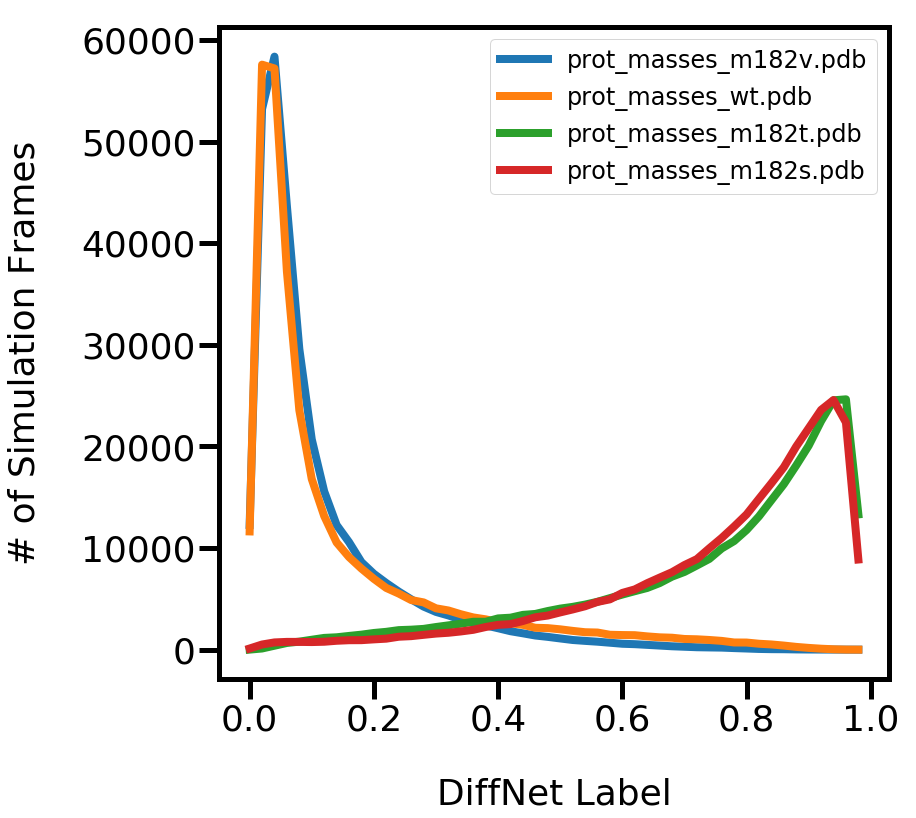

In [3]:
#Adapted from diffnets/analysis.py
from diffnets import utils
import os
import pickle
from collections import defaultdict
import matplotlib.pyplot as plt
%matplotlib inline

nn_dir = "/Users/mickdub/bowman_lab/scratch/tutorial/sae_e10_lr0001_lat50_rep0_em" #Let's assume this is the output path after training a diffnet
whitened_dir = "/Users/mickdub/bowman_lab/scratch/tutorial/whitened" #Let's assume this is the whitened_data directory

lab_fns = utils.get_fns(os.path.join(nn_dir,"labels"),"*.npy")
traj_d_path = os.path.join(whitened_dir,"traj_dict.pkl")
traj_d = pickle.load(open(traj_d_path, 'rb'))
lab_v = defaultdict(list)
for key,item in traj_d.items():
    for traj_ind in range(item[0],item[1]):
        lab = np.load(lab_fns[traj_ind])
        lab_v[key].append(lab)


plt.figure(figsize=(12,12))
axes = plt.gca()
lw = 8

leg_labels = []
for k in traj_d.keys():
    t = np.concatenate(lab_v[k])
    n, x = np.histogram(t, range=(0, 1), bins=50)
    leg_labels.append(k.split("/")[-1])
    plt.plot(x[:-1],n,label=k,linewidth=lw)


plt.xticks(fontsize=36)
plt.yticks(fontsize=36)
axes.set_xlabel('DiffNet Label',labelpad=40, fontsize=36)
axes.set_ylabel('# of Simulation Frames',labelpad=40,fontsize=36)
axes.tick_params(direction='out', length=20, width=5,
               grid_color='r', grid_alpha=0.5)
plt.legend(leg_labels,fontsize=24)

for axis in ['top','bottom','left','right']:
    axes.spines[axis].set_linewidth(5)

plt.show()
#plt.savefig(os.path.join(self.netdir,"label_plot.png"))

I generally look for 3 things here:
- 1) Labels distirbuted across the full 0-1 range
- 2) Separation between classes
- 3) At least some overlap between classes

## Plotting in pymol

-Open pymol, load in whitened_data/master.pdb, load sae_e10_lr0001_lat50_rep0_em/res-corr100.pml

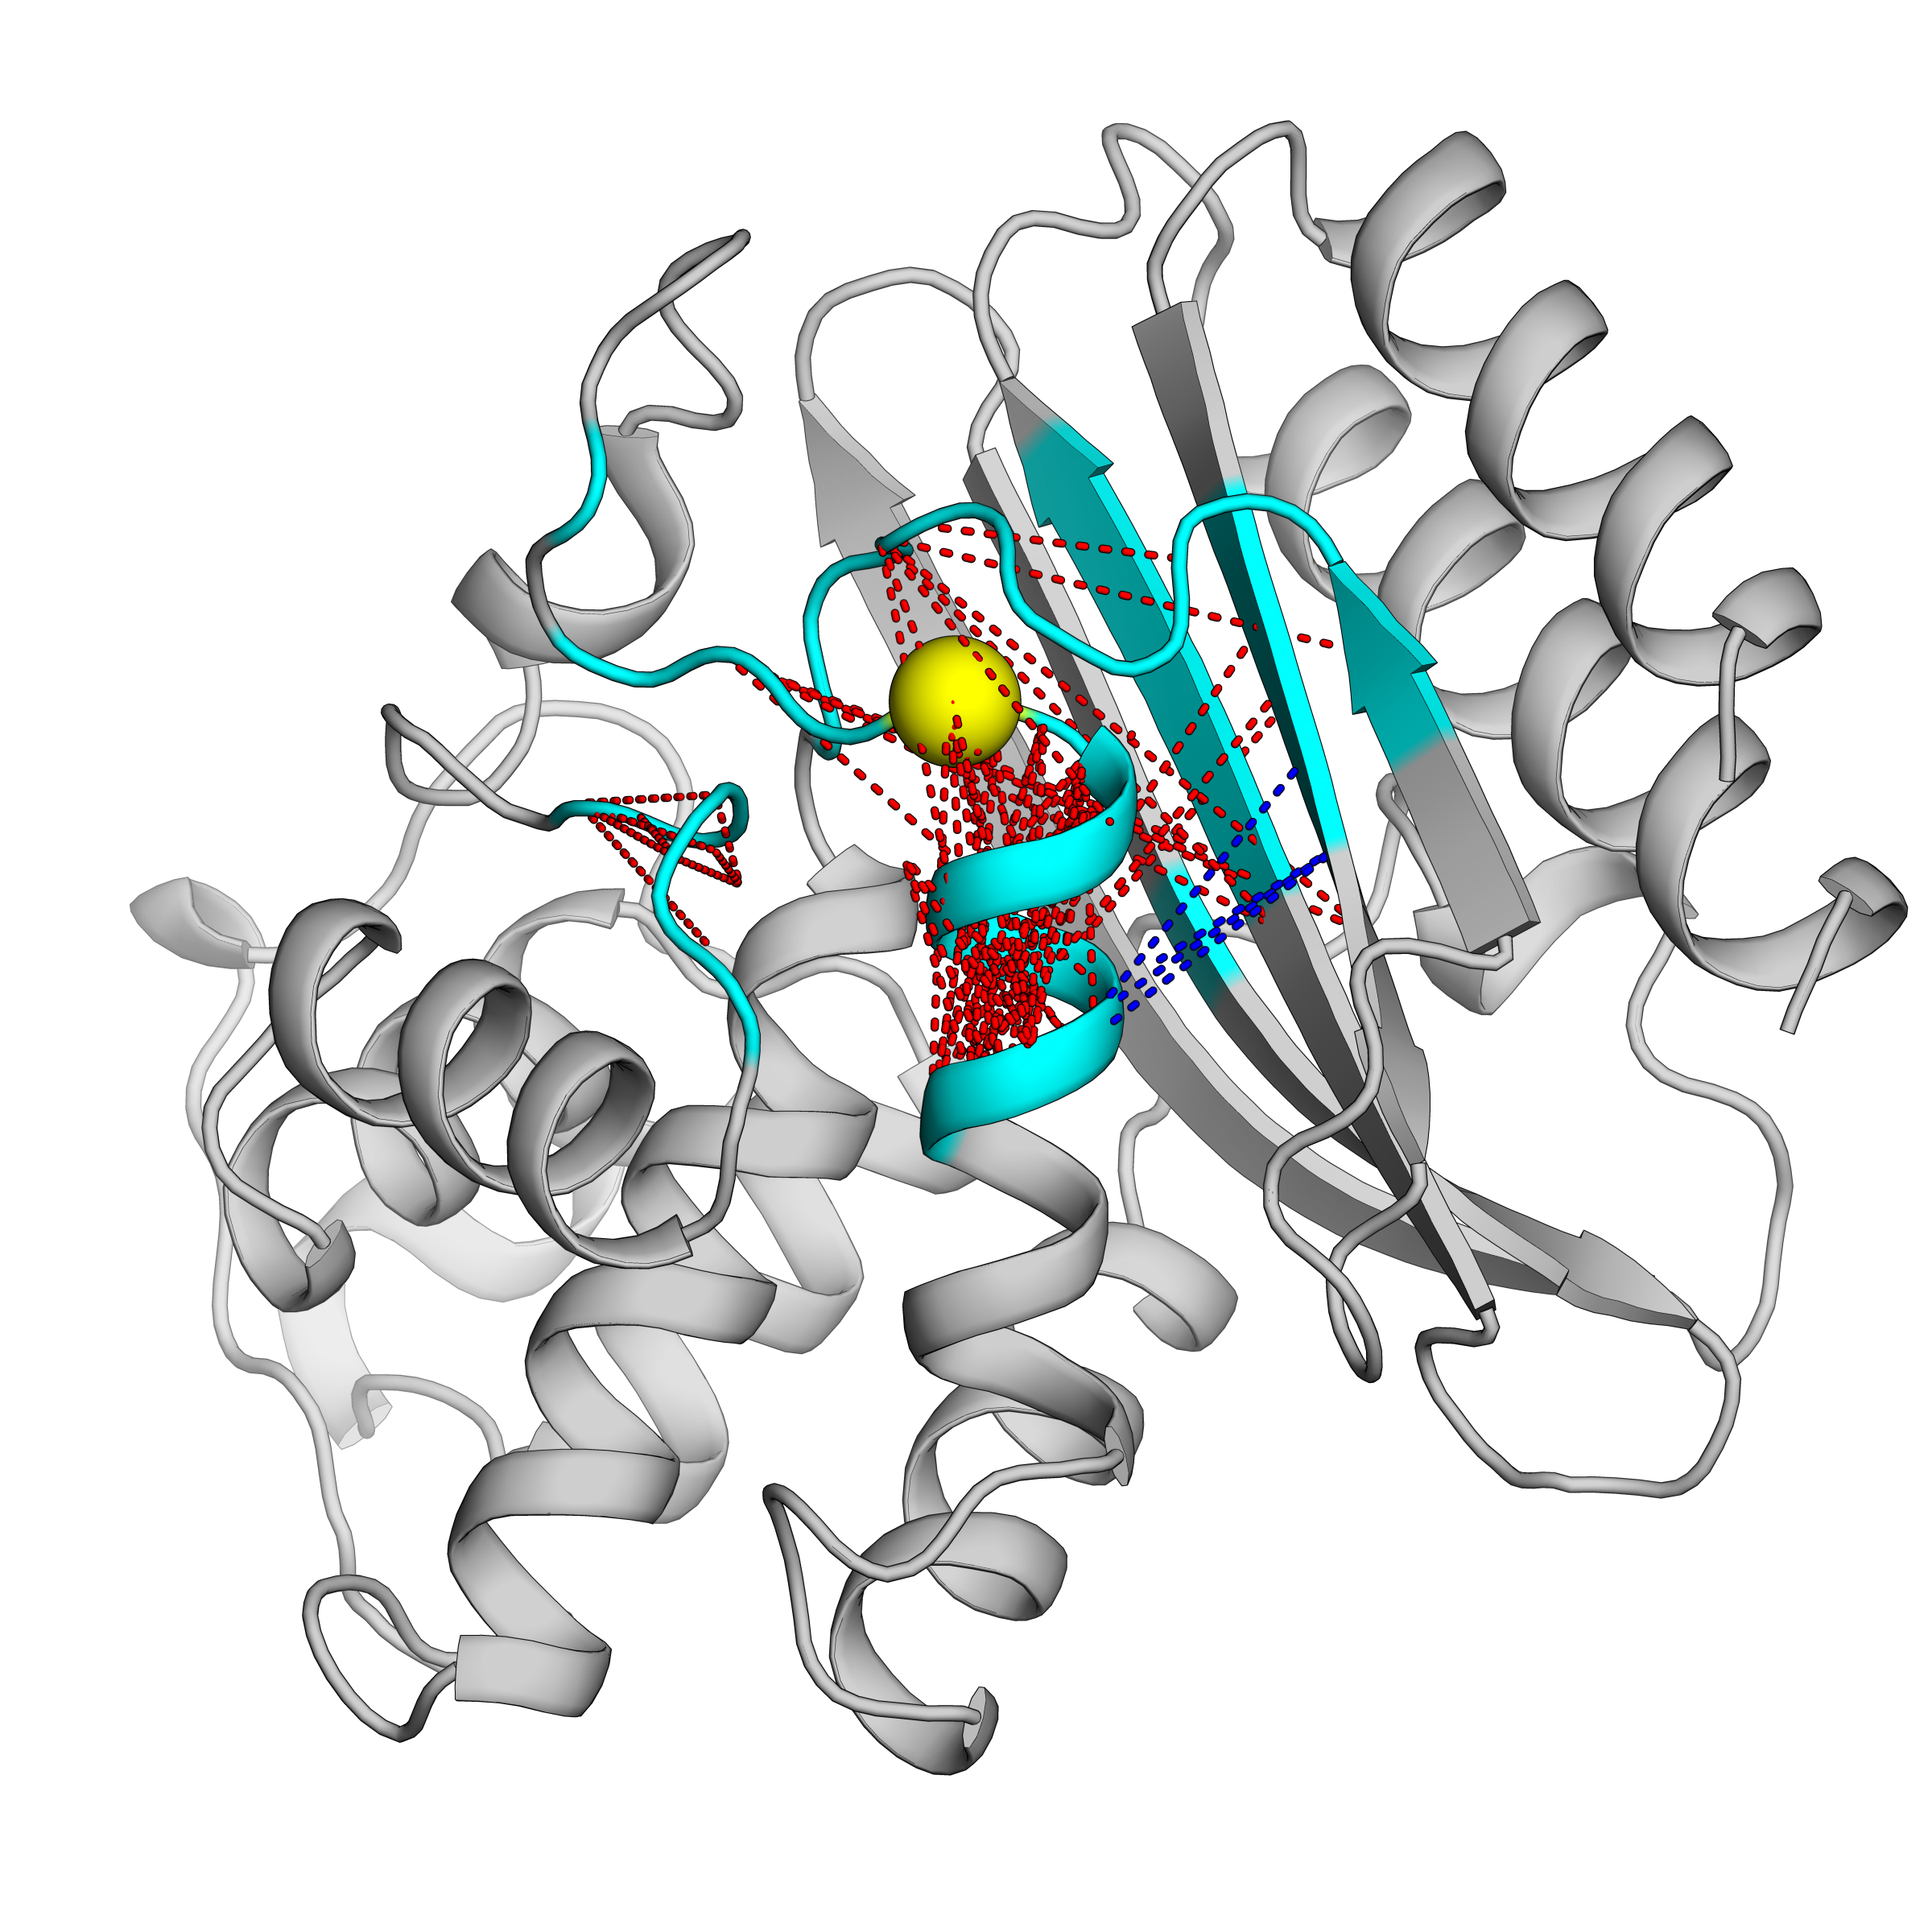

In [4]:
from IPython.display import Image
Image("/Users/mickdub/bowman_lab/scratch/tutorial/beta-lac-correlations.png")

-Cyan coloring and yellow sphere were done manually here. Also, you may get a "tubey" looking protein instead of the pretty cartoon. That is because the master.pdb structure by default doesn't have carbonyl oxygens so pymol can't recognize it properly. You can overlay the crystal structure pdb (as I did here).

## Morph

The morph_label directory provide a pdb containing 10 representative states morphing from a DiffNet classification label of 0 to 1. I typically split them into separate structures with MDTraj, then load them individually into pymol and color them along a gradient of white to some color I like.

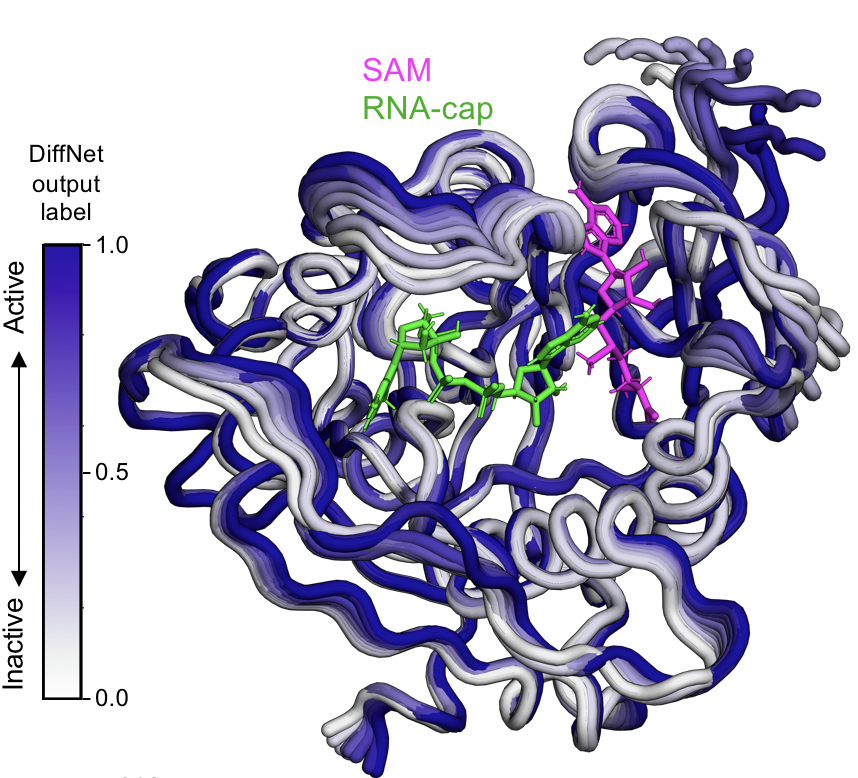

In [5]:
from IPython.display import Image
Image("/Users/mickdub/bowman_lab/scratch/tutorial/nsp16_morph.png")

Here is an example of me using the morph in a recent publication titled "SARS-CoV-2 Nsp16 activation mechanism and a cryptic pocket with pan-coronavirus antiviral potential"
https://www.cell.com/biophysj/fulltext/S0006-3495(21)00254-X